In [1]:
import os
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

## Training Splits

In [2]:
class BrainDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ["aneurysm", "tumor", "cancer"]  # List the directories (class folders)
        self.image_paths = []  # Store the paths of images
        self.labels = []       # Store the labels corresponding to images

        for label, class_name in enumerate(self.classes): # for each class (Normal = 0, Benign = 1, Malignant = 2)
            class_folder = os.path.join(data_dir, class_name)
            if os.path.isdir(class_folder):
                for file_name in os.listdir(class_folder):
                    if file_name.endswith(('.jpg', '.png', '.jpeg')):  # image datatypes
                        self.image_paths.append(os.path.join(class_folder, file_name)) # append images
                        self.labels.append(label) # append associated labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        image = PIL.Image.open(img_path)

        # Apply any transformations (if defined)
        if self.transform:
            image = self.transform(image)

        # Return the image and the label
        label = self.labels[idx]
        return image, label



In [3]:
img_transform = transforms.Compose([
    transforms.Resize((512, 512)), # resizing. some images are not 512x512
    transforms.Grayscale(),
    transforms.ToTensor()   # convert image to a tensor
])


brain_dataset = BrainDataset("../data/files/", img_transform)
print(f'Img Shape: {brain_dataset[0][0].shape}')

print(f'Dataset Size: {len(brain_dataset)}')
label_map = {0 : "aneurysm", 1 : "tumor", 2 : "cancer"}
cts = np.unique(brain_dataset.labels, return_counts = True)
for i in cts[0]:
    label = label_map[i]
    print(f'{label} Count: {cts[1][i]}, Percent: {100*cts[1][i]/len(brain_dataset):.2f}')

Img Shape: torch.Size([1, 512, 512])
Dataset Size: 259
aneurysm Count: 84, Percent: 32.43
tumor Count: 84, Percent: 32.43
cancer Count: 91, Percent: 35.14


In [4]:
torch.manual_seed(35)  # set seed

train_proportion = 0.7 # percent training set

train_size = int(train_proportion * len(brain_dataset)) 
test_size = len(brain_dataset) - train_size 

train_dataset, test_dataset = random_split(brain_dataset, [train_size, test_size]) # split dataset into train and test

In [5]:
print(f'Test Set Size: {len(test_dataset.indices)}')
cts = np.unique([brain_dataset[i][1] for i in test_dataset.indices], return_counts = True)
for i in cts[0]:
    label = label_map[i]
    print(f'Test {label} Count: {cts[1][i]}, Percent: {100*cts[1][i]/len(test_dataset.indices):.2f}')

Test Set Size: 78
Test aneurysm Count: 34, Percent: 43.59
Test tumor Count: 22, Percent: 28.21
Test cancer Count: 22, Percent: 28.21


In [6]:
# initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Modeling

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.linear = nn.Linear(32*64*64, 3)

    def forward(self, x):
        # 512 x 512
        x = self.pool(F.relu(self.conv1(x))) # 256x256
        x = self.pool(F.relu(self.conv2(x))) # 128x128
        x = self.pool(F.relu(self.conv3(x))) # 64x64

        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [8]:
model = CNN()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the appropriate device


num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [9]:
results = []
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    model.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        images, labels= images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])
    if i%2 == 0:
        print(f"Train Loss: {avg_loss:.4f}")
        print(f"Valid Loss: {avg_valid_loss:.4f}")



Epoch 1


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.13it/s]


Train Loss: 1.4489
Valid Loss: 0.9493
Epoch 2


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.62it/s]


Train Loss: 0.5267
Valid Loss: 0.4157
Epoch 3


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.57it/s]


Train Loss: 0.1828
Valid Loss: 0.2422
Epoch 4


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.56it/s]


Train Loss: 0.1148
Valid Loss: 0.1648
Epoch 5


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.47it/s]


Train Loss: 0.0584
Valid Loss: 0.1648
Epoch 6


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.46it/s]


Train Loss: 0.0745
Valid Loss: 0.1297
Epoch 7


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.59it/s]


Train Loss: 0.0269
Valid Loss: 0.1581
Epoch 8


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.48it/s]


Train Loss: 0.0652
Valid Loss: 0.1687
Epoch 9


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.48it/s]


Train Loss: 0.0234
Valid Loss: 0.0690
Epoch 10


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.65it/s]


Train Loss: 0.0398
Valid Loss: 0.0741
Epoch 11


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.68it/s]


Train Loss: 0.0250
Valid Loss: 0.0767
Epoch 12


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.52it/s]


Train Loss: 0.0164
Valid Loss: 0.0818
Epoch 13


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.46it/s]


Train Loss: 0.0241
Valid Loss: 0.0746
Epoch 14


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.44it/s]


Train Loss: 0.0148
Valid Loss: 0.0775
Epoch 15


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.28it/s]


Train Loss: 0.0383
Valid Loss: 0.0707
Epoch 16


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.50it/s]


Train Loss: 0.0292
Valid Loss: 0.1179
Epoch 17


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.68it/s]


Train Loss: 0.0233
Valid Loss: 0.0710
Epoch 18


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.18it/s]


Train Loss: 0.0272
Valid Loss: 0.0711
Epoch 19


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.62it/s]


Train Loss: 0.0163
Valid Loss: 0.0743
Epoch 20


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.41it/s]


Train Loss: 0.0115
Valid Loss: 0.0695


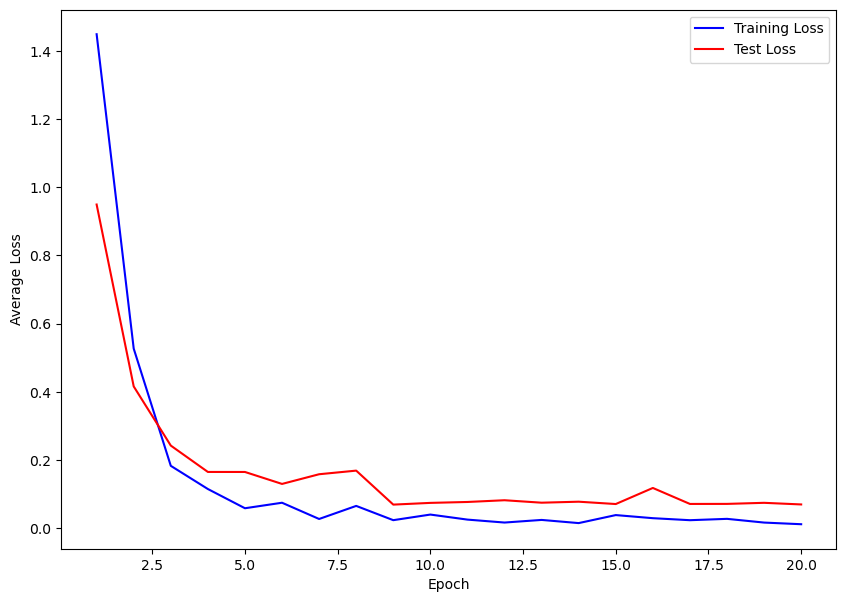

In [10]:
arr_results = np.array(results)
fig = plt.figure(figsize = (10,7))
plt.plot(arr_results[:, 0], arr_results[:, 1], label = 'Training Loss', c = 'b')
plt.plot(arr_results[:, 0], arr_results[:, 2], label = 'Test Loss', c = 'r')
plt.suptitle('')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [13]:
test_labels = []
test_pred_prob = []
test_preds = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure the model is on the correct device


for images, labels in test_dataloader:
    images = images.to(device)
    scores = model(images).to("cpu") # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    test_labels.extend(labels)
    test_pred_prob.extend(pred_prob)
    test_preds.extend(preds)

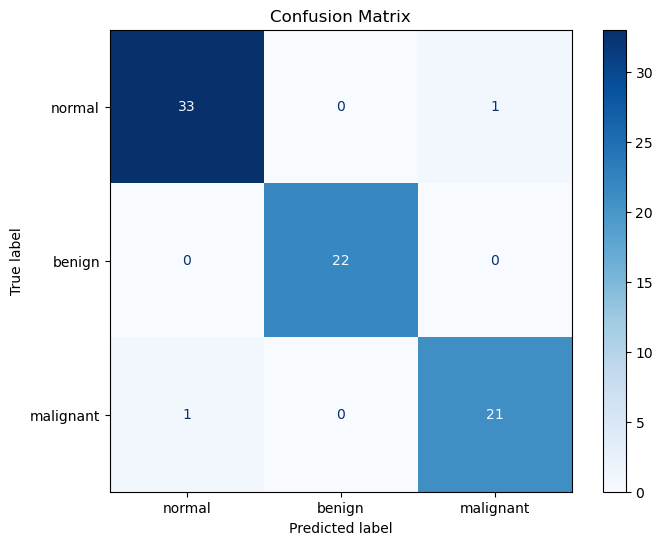

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert lists to NumPy arrays
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Define class names
class_names = ["normal", "benign", "malignant"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title("Confusion Matrix")
plt.show()